# $\hat{\Omega_m} = \Omega_b \frac{\hat{M_{\rm tot}}}{\hat{M_{\rm b}}}$

In [1]:
import os
import h5py 
import numpy as np 
from tqdm import tqdm

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
import corner as DFM

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
seed = 1
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

In [5]:
# dat_dir = '/Users/chahah/data/goleta/'
dat_dir = '/tigress/chhahn/cgpop/'

In [6]:
ftng = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
tng = ftng['props'][...]

w_tng = np.loadtxt(os.path.join(dat_dir, 'camels_tng.omega_thetag.dat'), unpack=True, usecols=[-1])

# restrict only to centrals
is_central = np.loadtxt(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.iscen'))
is_central = is_central.astype(bool)

tng = tng[:,is_central]
w_tng = w_tng[is_central]

is_sf = (np.log10(tng[14])-np.log10(tng[7]) > -10.)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [7]:
high_baryons = (tng[6] + tng[7]) / tng[9] > 0.9
print('%.2f have >90 percent baryons' % np.mean(high_baryons))

0.03 have >90 percent baryons


# $\hat{M}_{\rm tot} ( V_{\rm max}, M_*, R_*, A_{\rm SN1})$

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


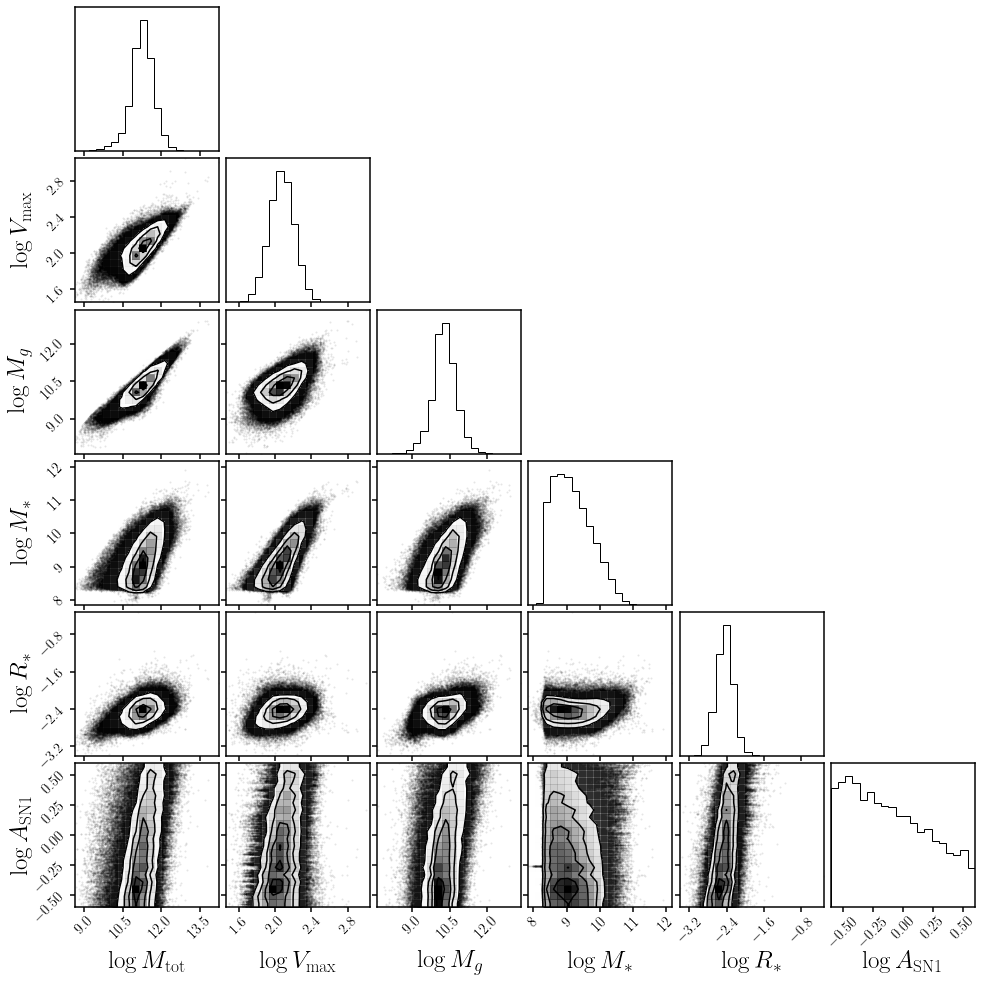

In [8]:
fig = DFM.corner(np.array([np.log10(tng[9]), np.log10(tng[10]), 
                           np.log10(tng[6]), np.log10(tng[7]), np.log10(tng[17]), 
                           np.log10(tng[2])]).T[is_sf & ~high_baryons], 
                 labels=[r'$\log M_{\rm tot}$', r'$\log V_{\rm max}$', 
                         r'$\log M_g$', r'$\log M_*$', r'$\log R_*$', r'$\log A_{\rm SN1}$'], 
                 label_kwargs={'fontsize': 25})

In [9]:
Y = np.log10(tng[9])[is_sf & ~high_baryons]
X = np.array([np.log10(tng[10]), np.log10(tng[6]), np.log10(tng[7]), 
              np.log10(tng[17]), np.log10(tng[2])]).T[is_sf & ~high_baryons]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [10]:
Ntrain = int(0.9 * X.shape[0])
print('Ntrain = %i' % Ntrain)
ishuffle = np.arange(X.shape[0])
np.random.shuffle(ishuffle)

Ntrain = 226607


In [11]:
prior = Ut.BoxUniform(low=torch.tensor([8.5]), high=torch.tensor([14]), device=device)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


In [17]:
nhidden = 128
nblocks = 5

anpe = Inference.SNPE(prior=prior, 
                      density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks), 
                      device=device)
anpe.append_simulations(torch.tensor(Y[ishuffle][:Ntrain][:,None]).to(device), 
                        torch.tensor(X[ishuffle][:Ntrain]).to(device))

p_y_x_estimator = anpe.train()
hat_Mtot = anpe.build_posterior(p_y_x_estimator)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 56 epochs.

In [18]:
torch.save(hat_Mtot, os.path.join(dat_dir, 'tng.hat_Mtot.sf.no_highb.pt'))

In [14]:
hat_Mtot = torch.load(os.path.join(dat_dir, 'tng.hat_Mtot.sf.no_highb.pt'), map_location=device)

In [15]:
ranks, mu_y, sig_y = [], [], []
for _x, _y in tqdm(zip(X[ishuffle][Ntrain:], Y[ishuffle][Ntrain:])):
    # sample posterior p(theta | x_test_i)
    y_prime = hat_Mtot.sample((10000,), 
            x=torch.as_tensor(_x.astype(np.float32)).to(device), 
            show_progress_bars=False)
    y_prime = np.array(y_prime.detach().cpu())

    # calculate percentile score and rank
    ranks.append(np.mean(y_prime < _y))
    mu_y.append(np.mean(y_prime))
    sig_y.append(np.std(y_prime))

25179it [01:21, 310.00it/s]


[]

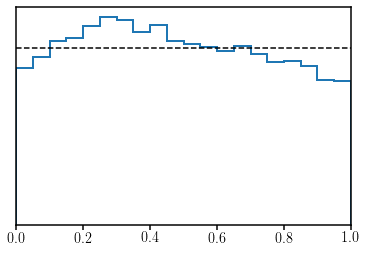

In [16]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
_ = sub.hist(ranks, range=(0., 1), bins=20, histtype='step', linewidth=2, density=True)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlim(0., 1.)
sub.set_yticks([])

(8.5, 13.5)

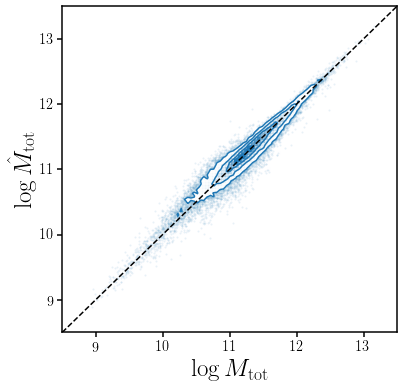

In [17]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
DFM.hist2d(Y[ishuffle][Ntrain:], np.array(mu_y), bins=100, color='C0')
#sub.errorbar(Y[ishuffle][Ntrain:Ntrain+1000], mu_y, yerr=sig_y, fmt='.C0')
sub.plot([8.5, 13.5], [8.5, 13.5], c='k', ls='--')
sub.set_xlabel(r'$\log M_{\rm tot}$', fontsize=25)
sub.set_xlim(8.5, 13.5)
sub.set_ylabel(r'$\log \hat{M}_{\rm tot}$', fontsize=25)
sub.set_ylim(8.5, 13.5)